In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

BATCH_SIZE = 16

In [8]:
my_transform = transforms.Compose([
#     transforms.RandomResizedCrop(size=480,scale=(0.8, 1.0), ratio=(1,1)),
    transforms.RandomResizedCrop(size=224,scale=(0.8, 1.0), ratio=(1,1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])


data_dir = 'images_train'

image_datasets = datasets.ImageFolder(os.path.join(data_dir), my_transform)


class_names = image_datasets.classes
dataset_sizes = len(image_datasets)

train_size = int(0.7 * dataset_sizes)
test_size = dataset_sizes - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size])

dataloaders_train = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
dataloaders_test = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=BATCH_SIZE, num_workers=2)


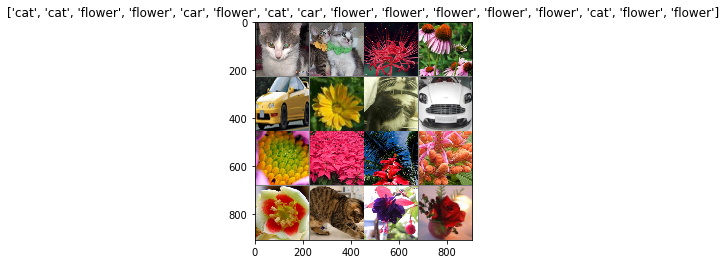

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4, padding=2)

imshow(out, title=[class_names[x] for x in classes])

In [125]:
import torch.nn as nn
import torch.nn.functional as F


class classi(nn.Module):
    def __init__(self):
        super(classi, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv2_bn = nn.BatchNorm2d(12)
        
        self.conv3 = nn.Conv2d(12, 24, 5)
        self.conv3_bn = nn.BatchNorm2d(24)
        
        self.conv4 = nn.Conv2d(24, 48, 5)
        self.conv4_bn = nn.BatchNorm2d(48)

        
        self.fc1 = nn.Linear(26*26*48, 120)
        self.fc1_bn = nn.BatchNorm1d(120)

        
        self.fc2 = nn.Linear(120, 50)
        self.fc2_bn = nn.BatchNorm1d(50)

        
        self.fc3 = nn.Linear(50, 10)
        self.fc3_bn = nn.BatchNorm1d(10)
        
        self.fc4 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))

        x = x.view(-1,26*26*48)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x


classi = classi()


In [116]:
print(classi)

<bound method classi.forward of classi(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv4_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32448, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=50, bias=True)
  (fc2_bn): BatchNorm1d(50, eps=1e-05, mo

In [114]:
import torch.optim as optim

#device = torch.device("cpu")
device = torch.device("cuda:0")

classi.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classi.parameters(), lr=10**(-2), momentum=0.5)

In [115]:
for epoch in range(15): #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders_train, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classi(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('%d loss: %.3f' %(epoch + 1,running_loss*BATCH_SIZE))
    
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = classi(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            
    train_accuracy = 100 * correct / total
    print('Accuracy of the network on train set: %d %%' % (train_accuracy))    
    

    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = classi(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print('Accuracy of the network on test set: %d %%' % (test_accuracy))
    

print('Finished Training')

1 loss: 72.746
Accuracy of the network on train set: 92 %
Accuracy of the network on test set: 95 %
2 loss: 60.199
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 92 %
3 loss: 65.460
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 93 %
4 loss: 30.988
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 93 %
5 loss: 34.779
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 94 %
6 loss: 56.415
Accuracy of the network on train set: 93 %
Accuracy of the network on test set: 93 %
7 loss: 45.917
Accuracy of the network on train set: 92 %
Accuracy of the network on test set: 93 %
8 loss: 52.943
Accuracy of the network on train set: 93 %
Accuracy of the network on test set: 92 %
9 loss: 28.300
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 93 %
10 loss: 64.765
Accuracy of the network on train set: 94 %
Accuracy of the network on test set: 93 %

In [73]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders_test:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = classi(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network : %d %%' % (100 * correct / total))

Accuracy of the network : 85 %


# TRANSFER LEARNING

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':
                for inputs, labels in dataloaders_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    epoch_loss = running_loss / train_size
                    epoch_acc = running_corrects.double() / train_size
                    
            if phase == 'val':
                for inputs, labels in dataloaders_test:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    epoch_loss = running_loss / test_size
                    epoch_acc = running_corrects.double() / test_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_test):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda:0")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2053 Acc: 0.9203
val Loss: 0.0114 Acc: 1.0000

Epoch 1/4
----------
train Loss: 0.0260 Acc: 0.9937
val Loss: 0.0076 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.0204 Acc: 0.9964
val Loss: 0.0044 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.0200 Acc: 0.9964
val Loss: 0.0029 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.0180 Acc: 0.9946
val Loss: 0.0036 Acc: 1.0000

Training complete in 0m 48s
Best val Acc: 1.000000


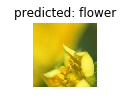

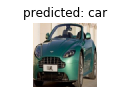

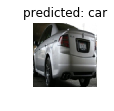

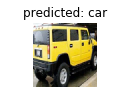

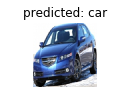

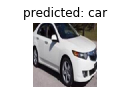

In [13]:
visualize_model(model_ft)

# save load and test model

In [16]:
filename = 'model_transfer_learning.pth'
torch.save(model_ft, filename)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

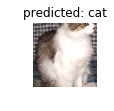

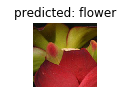

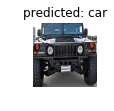

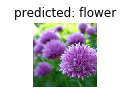

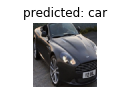

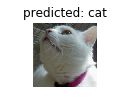

In [15]:
loaded_model = torch.load(filename)
device = torch.device("cuda:0")
loaded_model = loaded_model.to(device)

visualize_model(loaded_model)